# Melanoma Classification with MLP Model

In this notebook, a simple neural network based on the melanoma dataset will be build in order to assess initial performance.
The notebook works with data previously saved to the disk. To create this script, the model template was used.

The script that should be performed before this is the script: data_preparation_20192020.ipynb


<b>Running the script on cluster</b>
Please keep in mind the following
1. Load ALL images rather than a subset by changing to get_all_img_paths(img_folder) in Step 2 (get image paths 
2. The path to the data can be modified in Step 2 (get image paths + load data)
3. Make sure export is set to true
4. Save the results that are stored in the export folder and upload them seperately on google drive or github. The folder "export" is not tracked on github!!!

## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

 #### Random State

In [2]:
from utilities import random_state
random_state = random_state() 

#### Export Config

In [3]:
export_results = True
export_folder = 'export'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### Timer

Start the timer

In [ ]:
import time
start = time.time()

## 2. Get data

#### Get image paths
For developing models on the cluster the max_images parameter should be removed. Instead call the method get_all_img_paths(img_folder).

In [4]:
from utilities import get_img_paths

img_folder_train = "data/train" # change this to the folder including your images!
img_folder_test = "data/test"
max_images_train = 800
max_images_test = 100

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load data
Loads the images specified in img_paths into a data frame. This includes resizing the images and flattening them into an array and may take a while.

In [5]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train.csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test.csv"

# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, img_paths_test, groundtruth_file_test, option);

#### Split into target and predictors

In [6]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

## 3. Train model

In [7]:
import sklearn 

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras.metrics import Recall

# define model
model = Sequential()
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # note: for some reason sigmoid produces high accuracy low recall while softmax produces the exact opposite

# compile model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', Recall()])

In [8]:
# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=50)

Epoch 1/50
7/7 [==============================] - 3s 191ms/step - loss: 1.9569 - accuracy: 0.8325 - recall: 0.2308 - val_loss: 22.8139 - val_accuracy: 0.7900 - val_recall: 0.0000e+00
Epoch 2/50
7/7 [==============================] - 1s 89ms/step - loss: 1.3677 - accuracy: 0.9837 - recall: 0.0000e+00 - val_loss: 11.8275 - val_accuracy: 0.7900 - val_recall: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 1s 91ms/step - loss: 0.5464 - accuracy: 0.9837 - recall: 0.0000e+00 - val_loss: 1.4627 - val_accuracy: 0.7900 - val_recall: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 1s 89ms/step - loss: 0.3862 - accuracy: 0.9438 - recall: 0.0000e+00 - val_loss: 0.6927 - val_accuracy: 0.7800 - val_recall: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 1s 90ms/step - loss: 0.6898 - accuracy: 0.9837 - recall: 0.0000e+00 - val_loss: 0.6894 - val_accuracy: 0.7800 - val_recall: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 1s 88ms/step - loss: 0.746

In [9]:
# print out model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                983060    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 983,081
Trainable params: 983,081
Non-trainable params: 0
_________________________________________________________________


## 4. Test model

#### Evaluate loss and accuracy during training

In [10]:
# evaluate the model
_, train_acc, train_recall = model.evaluate(X_train, y_train)
_, test_acc, test_recall  = model.evaluate(X_test, y_test)

print('Accuracy\tTrain: %.3f, Test: %.3f' % (train_acc, test_acc))

print('Recall\tTrain: %.3f, Test: %.3f' % (train_recall, test_recall))

4/4 [==============================] - 0s 12ms/step - loss: 0.6116 - accuracy: 0.7900 - recall: 0.0000e+00
Accuracy	Train: 0.984, Test: 0.790
Recall	Train: 0.000, Test: 0.000


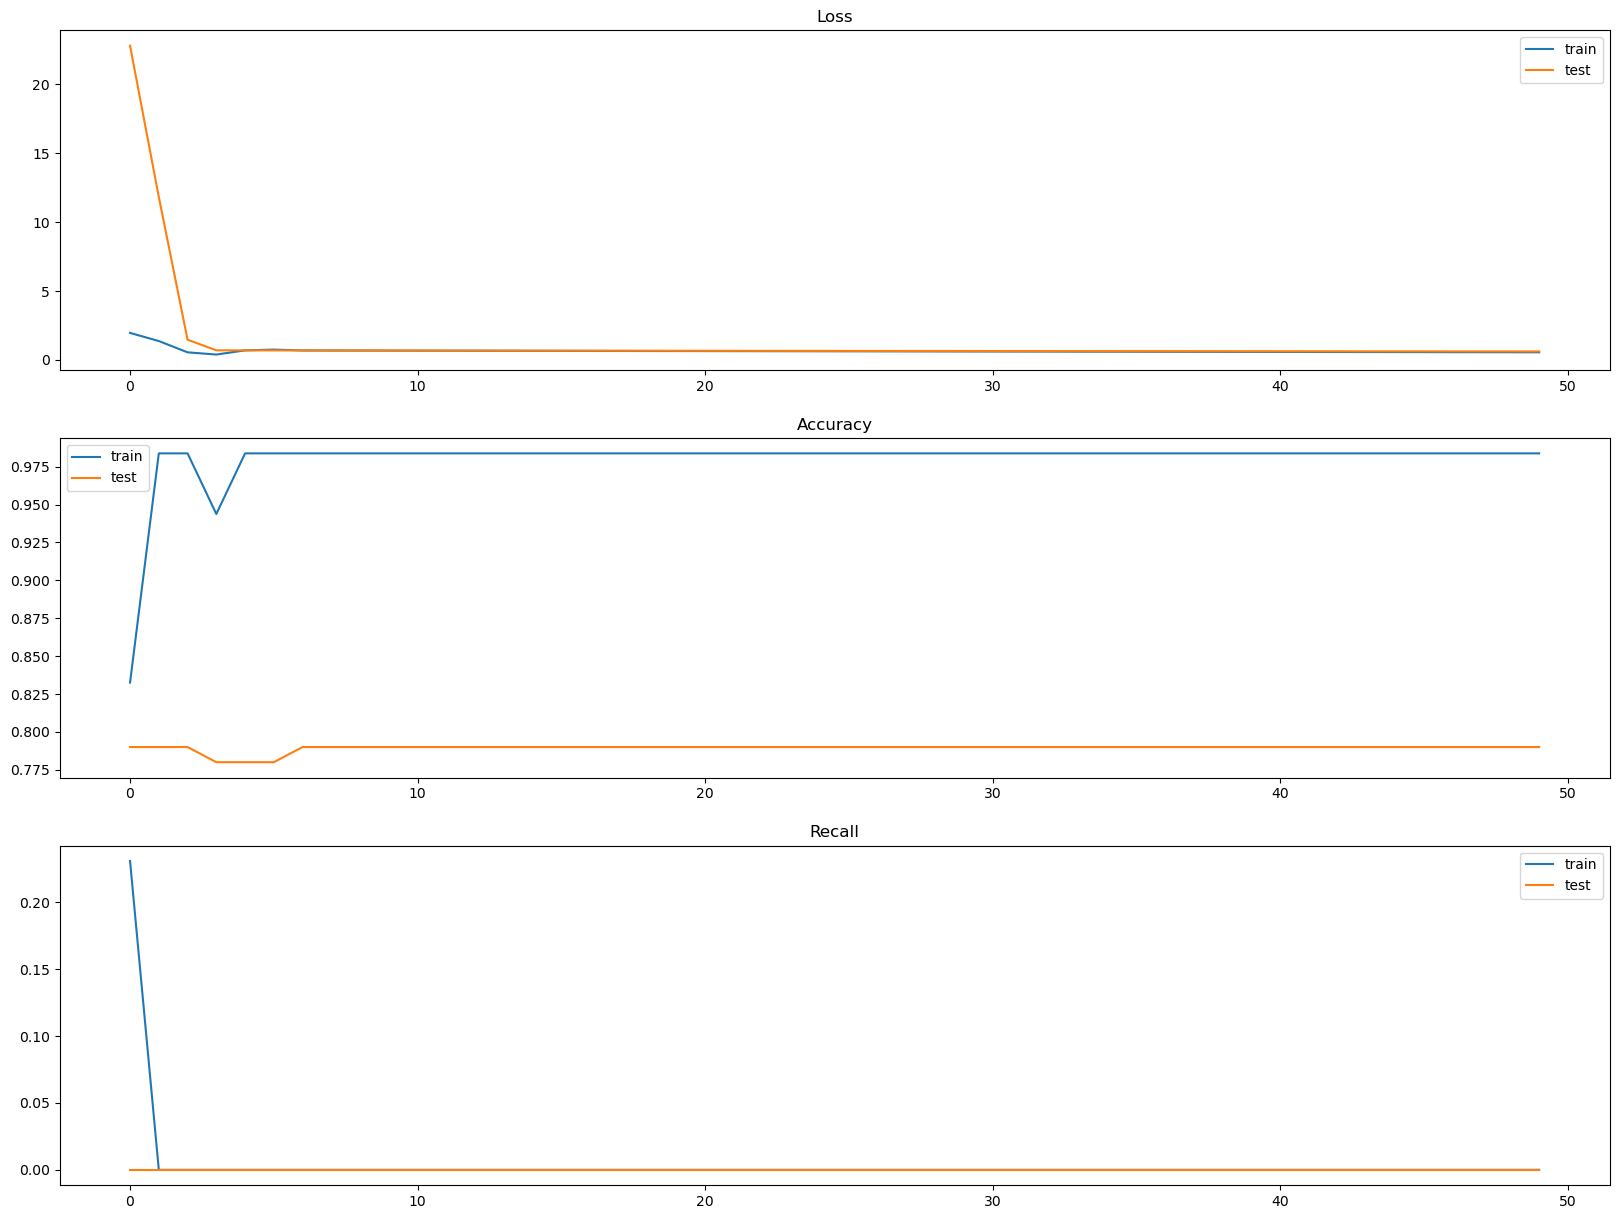

In [11]:
from matplotlib import pyplot

_, axs = pyplot.subplots(3, 1, figsize=(20,15))

# plot loss during training
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='test')
axs[0].set_title("Loss")
axs[0].legend()

# plot accuracy during training
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='test')
axs[1].set_title("Accuracy")
axs[1].legend()

# plot recall during training
axs[2].plot(history.history['recall'], label='train')
axs[2].plot(history.history['val_recall'], label='test')
axs[2].set_title("Recall")
axs[2].legend()

if export_results:
    pyplot.savefig(export_folder + "/loss_and_accuracy_during_training_"+datetime.datetime.now().strftime(date_format)+".png")

pyplot.show()

#### Predict test set

In [12]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

#### Print report

In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, digits=4)
print(f'\nClassification_report=\n{report}')

if export_results:
    file = open(export_folder + "/classification_report_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
    file.write(report)
    file.close()


Classification_report=
              precision    recall  f1-score   support

           0     0.7900    1.0000    0.8827        79
           1     0.0000    0.0000    0.0000        21

    accuracy                         0.7900       100
   macro avg     0.3950    0.5000    0.4413       100
weighted avg     0.6241    0.7900    0.6973       100



C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\apfel\anaconda3\envs\tf2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Timer 
Stop the timer

In [ ]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

#### Display images and predictions

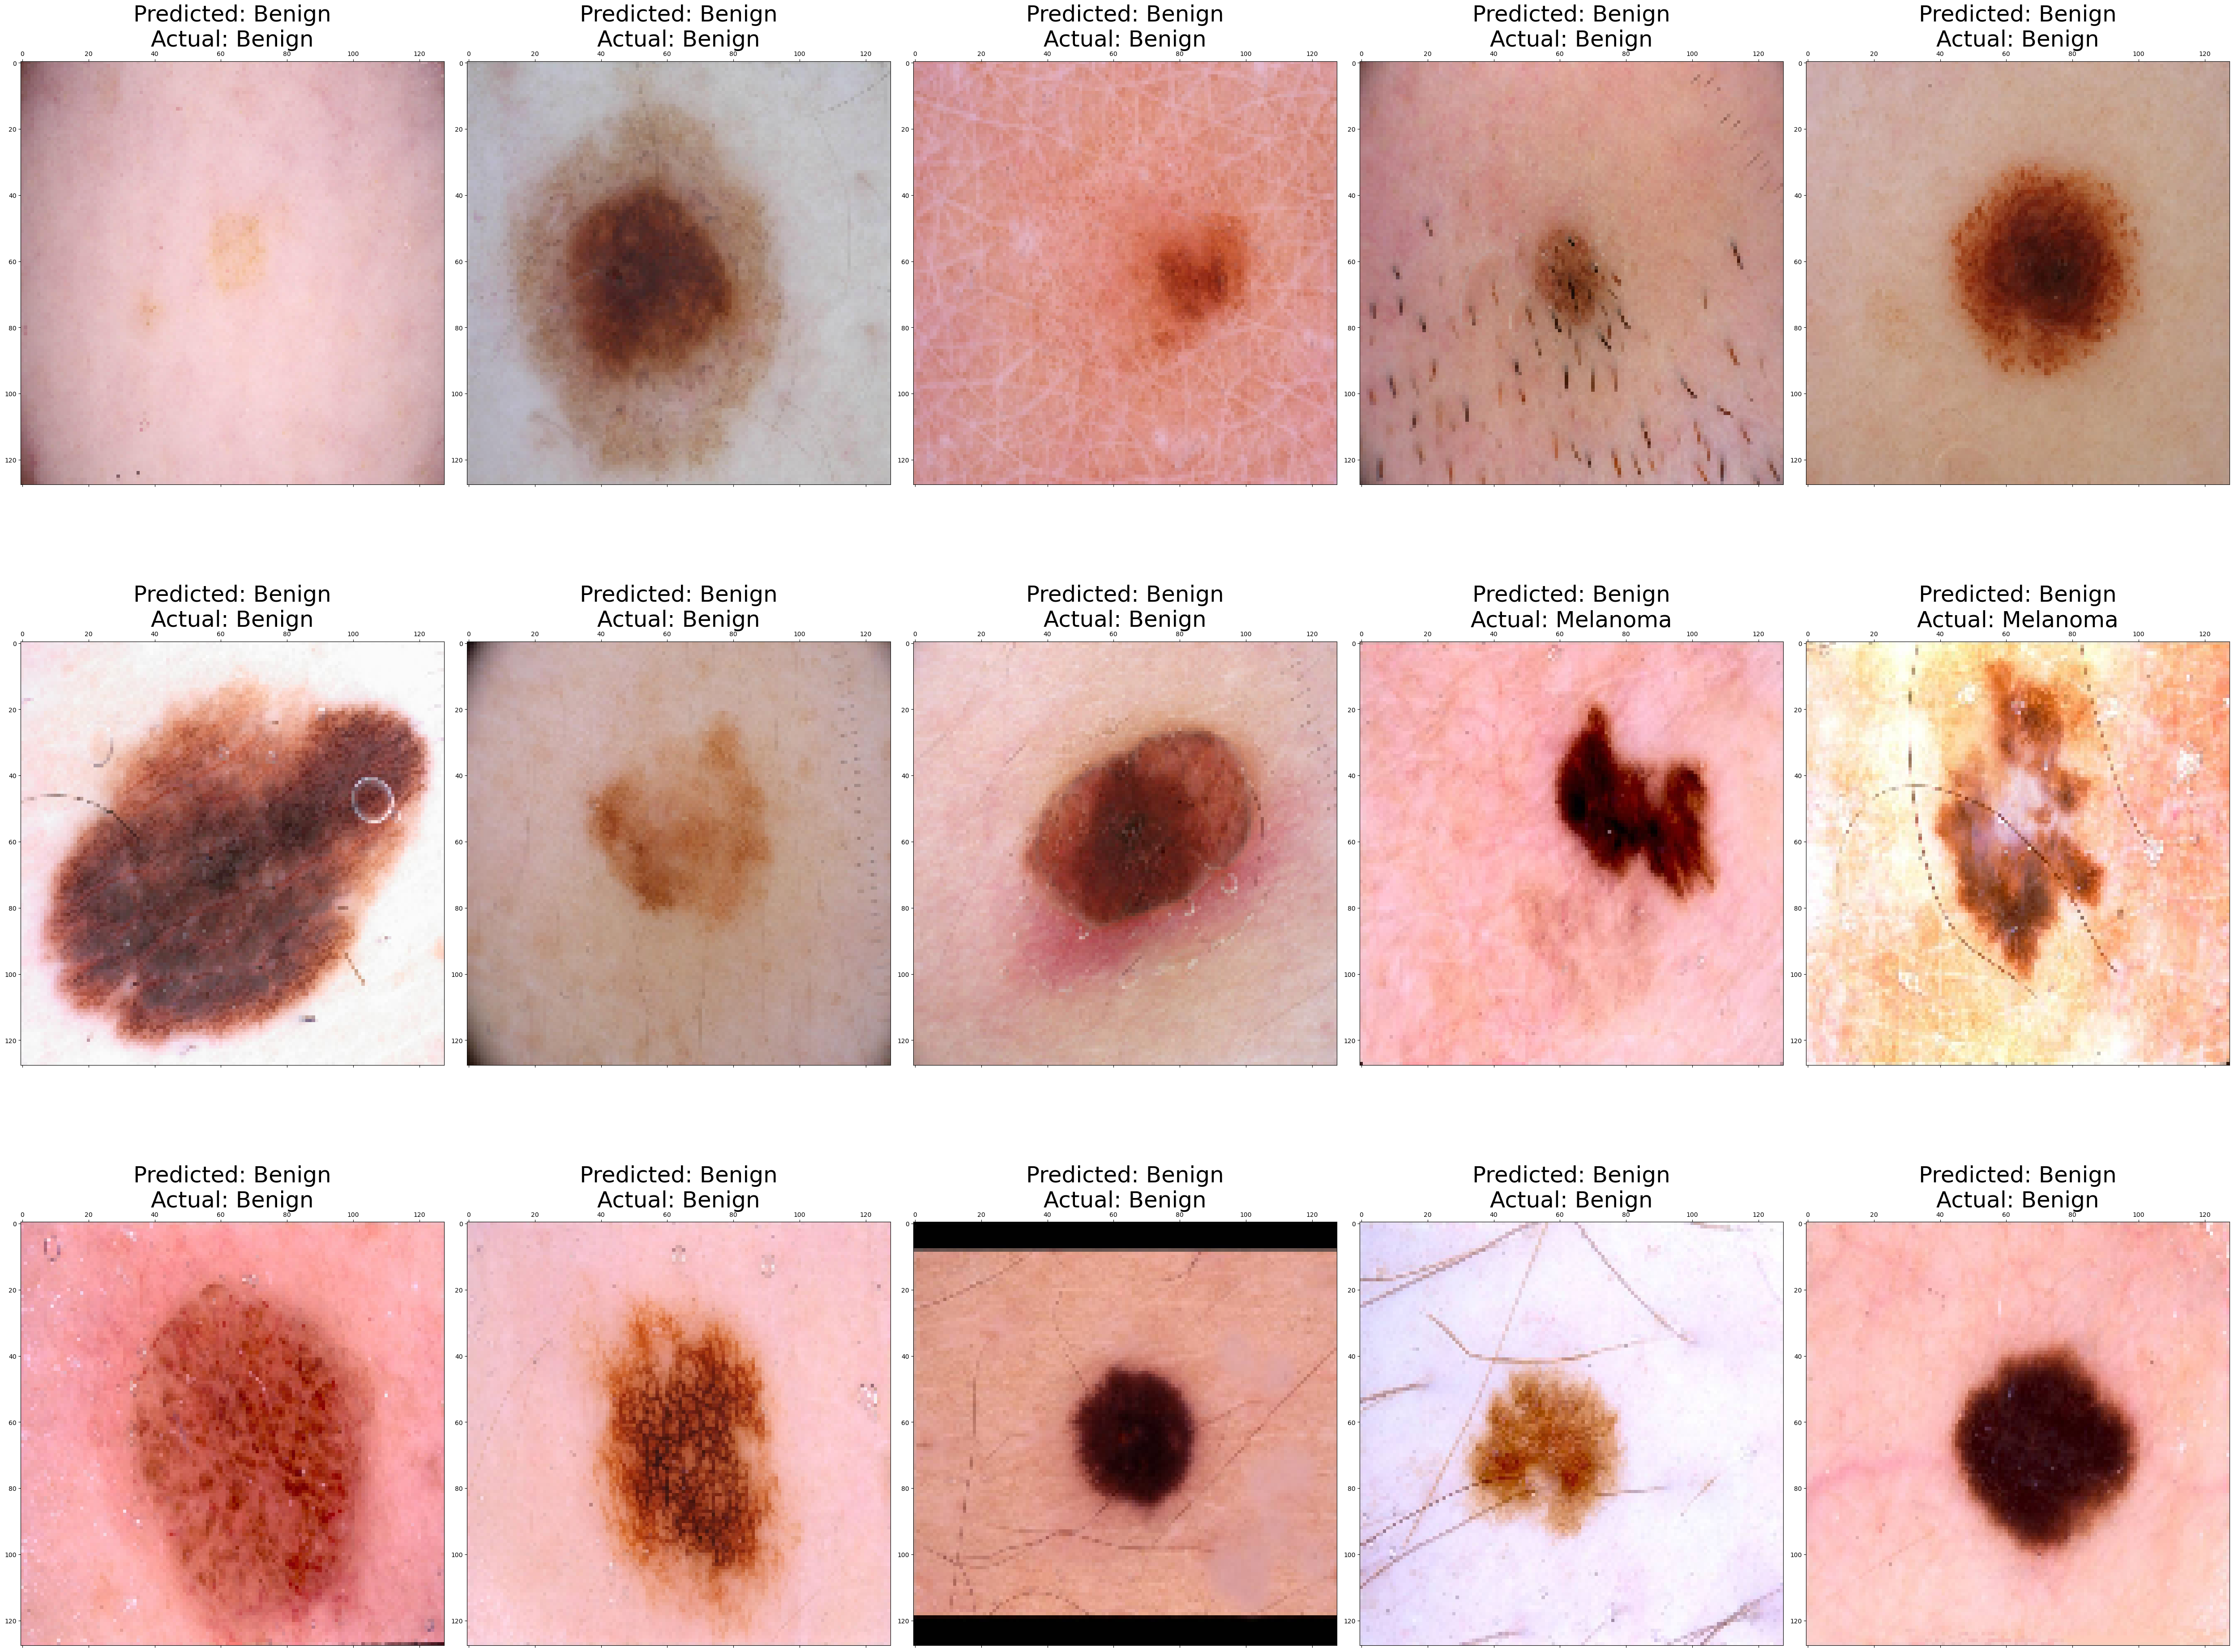

In [14]:
from utilities import display_results

plt_all = display_results(X_test, y_pred, y_test, 15)

if export_results:
    plt_all.savefig(export_folder + "/classification_results_"+datetime.datetime.now().strftime(date_format)+".png")

plt_all.show()

#### Display wrongly classified images

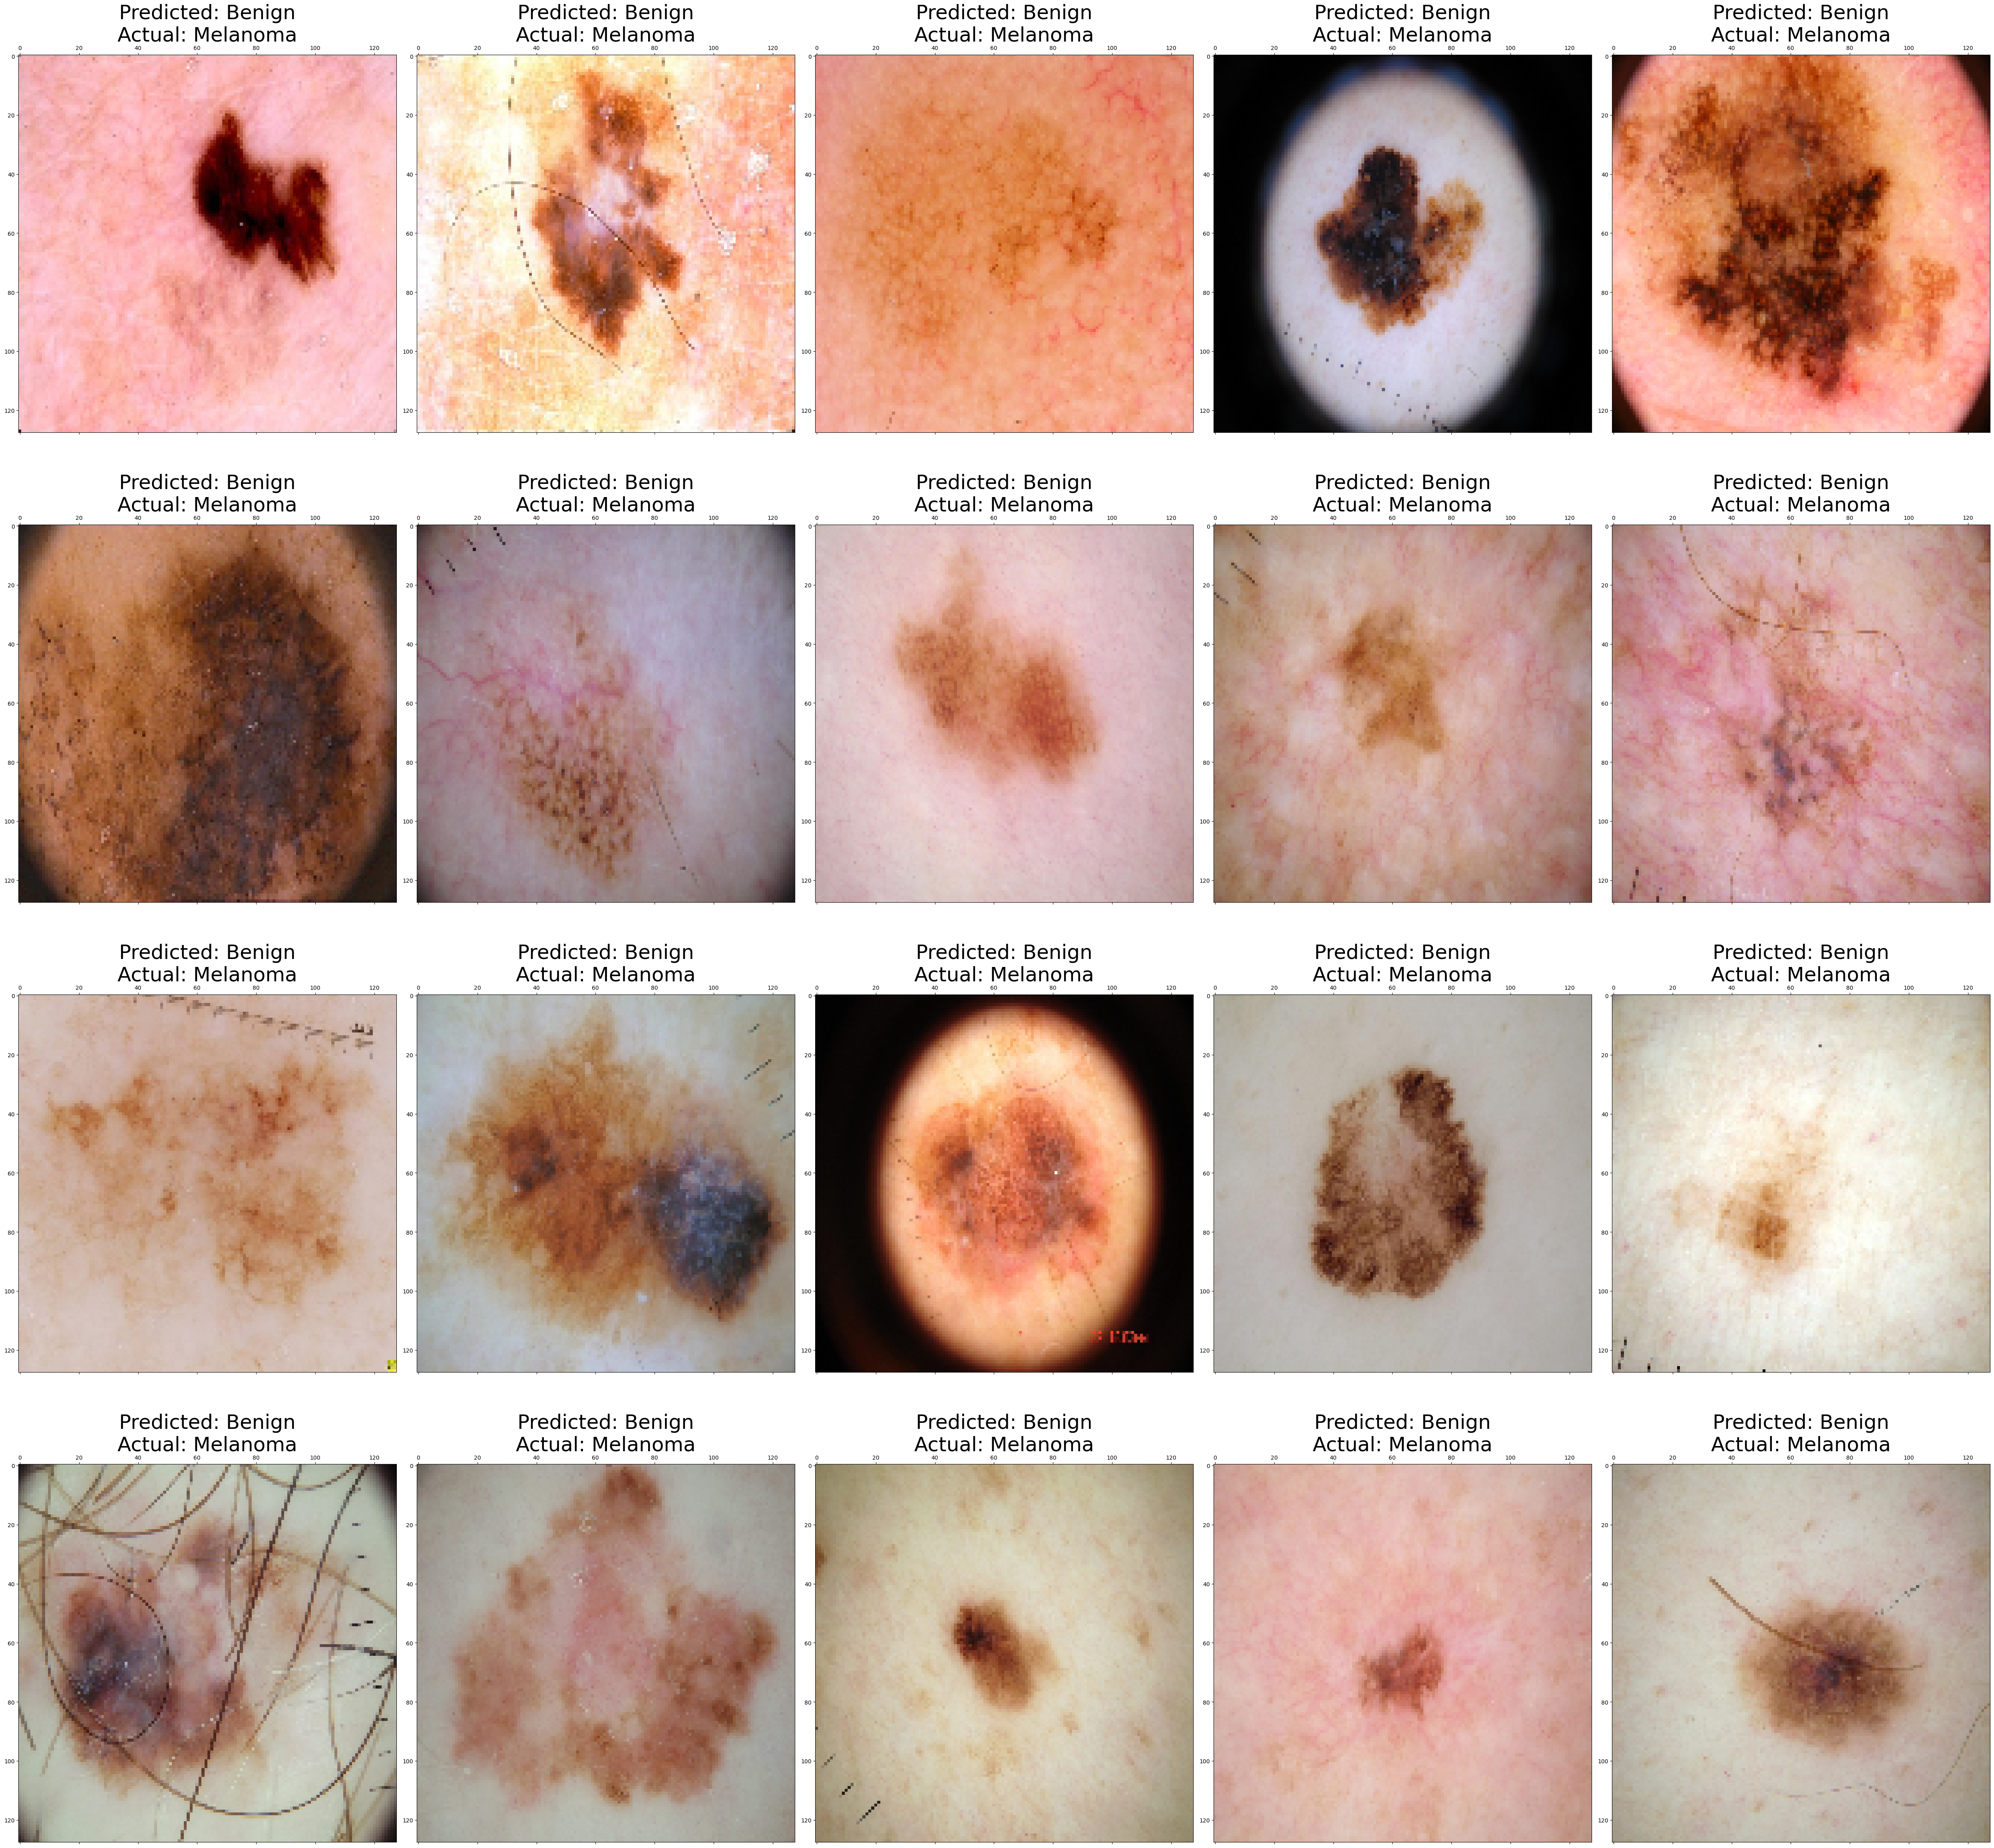

In [15]:
from utilities import display_interesting_results

plt_wrong = display_interesting_results(X_test, y_pred, y_test)

if export_results:
    plt_wrong.savefig(export_folder + "/incorrect_classification_results_"+datetime.datetime.now().strftime(date_format)+".png")
    
plt_wrong.show()